<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#загрузка-данных,-просмотр" data-toc-modified-id="загрузка-данных,-просмотр-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>загрузка данных, просмотр</a></span></li><li><span><a href="#Лемматизация-данных" data-toc-modified-id="Лемматизация-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация данных</a></span></li><li><span><a href="#Подготовка-данных-к-обучению" data-toc-modified-id="Подготовка-данных-к-обучению-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных к обучению</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Дообучим-выбранную-модель-на-всех-оставшихся-данных-перед-финальной-и-проведем-тест-на-тестовой-выборке." data-toc-modified-id="Дообучим-выбранную-модель-на-всех-оставшихся-данных-перед-финальной-и-проведем-тест-на-тестовой-выборке.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Дообучим выбранную модель на всех оставшихся данных перед финальной и проведем тест на тестовой выборке.</a></span></li><li><span><a href="#Построим-ROC-AUC" data-toc-modified-id="Построим-ROC-AUC-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Построим ROC-AUC</a></span></li><li><span><a href="#Найдем-лучшую-отсечку-по-вероятности" data-toc-modified-id="Найдем-лучшую-отсечку-по-вероятности-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Найдем лучшую отсечку по вероятности</a></span></li></ul></li><li><span><a href="#Предсказания-выбранной-модели" data-toc-modified-id="Предсказания-выбранной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предсказания выбранной модели</a></span><ul class="toc-item"><li><span><a href="#Построим-матрицу" data-toc-modified-id="Построим-матрицу-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Построим матрицу</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Классификация текстовых данных

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. 
F1 модели должна быть не меньше 0.75. 

## Подготовка

### загрузка данных, просмотр

In [15]:
import warnings

import os
import io
import re
import spacy

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer 

from catboost import CatBoostClassifier

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.simplefilter("ignore")

In [16]:
try:
    data = pd.read_csv('')
    
except:
    from google.colab import files
    uploaded = files.upload()
    data = pd.read_csv(io.BytesIO(uploaded['']))
    

In [17]:
print(data.info())
display(data.head())
print()
print(data.isnull().sum().sort_values(ascending=False).head(10))
data_original = data
print(data[data['toxic']==1].count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



Unnamed: 0    0
text          0
toxic         0
dtype: int64
Unnamed: 0    16186
text          16186
toxic         16186
dtype: int64


    для анализа и обучения предоставлены 159 тысяч текстов с оценкой их токсичности, 16 тысяч текстов токсичны. в данных нет пропусков, формат соответвует назначению.

### Лемматизация данных

In [18]:
#создаем лемматайзер Spacy
nlp = spacy.load('en_core_web_sm')
def lemmatize_spacy(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [19]:
tqdm.pandas()
new_corpus = []

for doc in tqdm(nlp.pipe(data_original['text'], batch_size=64, n_process=-1, disable=["parser", "ner"]), total=len(data_original['text'])):
    word_list = [tok.lemma_ for tok in doc]
    new_corpus.append(' '.join(word_list))

data['lemm_spacy_new'] = new_corpus   

100%|██████████| 159292/159292 [05:02<00:00, 527.20it/s]


In [20]:
display(data.head())

,Unnamed: 0,text,toxic,lemm_spacy_new
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation \n why the edit make under my user...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww ! he match this background colour I be s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n More \n I can not make any real suggestio..."
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."


### Подготовка данных к обучению

In [21]:
rand = 12345
remaining, test = train_test_split(
    data, 
    test_size=0.20, 
    stratify = data['toxic'], 
    random_state = rand
)

leftovers, train = train_test_split(
    remaining, 
    test_size=0.4, 
    stratify = remaining['toxic'], 
    random_state = rand
)


x_train = train['lemm_spacy_new']
y_train = train['toxic']
x_test = test['lemm_spacy_new']
y_test = test['toxic']

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50974,)
(50974,)
(31859,)
(31859,)


## Обучение

### RandomForestClassifier

<font color='White' size=+1> Создаем Pipeline и tf-idf векторизатор, обучаем регрессию


In [48]:
%%time
#RandomForestClassifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'), ngram_range=(1, 3), max_df = 0.25)),
    ('forest', RandomForestClassifier())
     ])
parameters = {
    'forest__max_depth': range(10, 50, 10),
    'forest__n_estimators': range(10, 50, 10)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune.fit(x_train, y_train)
print('Лучший лес', grid_search_tune.best_estimator_)
forest = grid_search_tune.best_estimator_
print('f1 леса', grid_search_tune.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучший лес Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('forest',
                 RandomForestClassifier(max_depth=40, n_estimators=10))])
f1 леса 0.0046173828951828096
CPU times: total: 22.5 s
Wall time: 2min 48s


    Лес дал очень плохие результаты, очевидно, эта модель не подходит для текстов

### LogisticRegression

In [38]:
%%time
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'), ngram_range=(1, 3), max_df = 0.25)),
    ('logreg', LogisticRegression())
     ])
parameters = {
    'logreg__C': range(1, 11, 2),
    'logreg__solver': ['lbfgs', 'newton-cg', 'sag'],
    'logreg__class_weight': [None, 'balanced']
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune.fit(x_train, y_train)
print('Лучшая регрессия', grid_search_tune.best_estimator_)
logreg = grid_search_tune.best_estimator_
print('f1 регрессии', grid_search_tune.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Лучшая регрессия Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logreg', LogisticRegression(C=9, class_weight='balanced'))])
f1 регрессии 0.7591862331910101
CPU times: total: 2min 51s
Wall time: 15min 45s


    Лучшая модель 
    LogisticRegression
    (C=9, class_weight='balanced')
    f1 регрессии 0.7591862331910101
    
    хороший результат, проходим по метрике, попробуем ее улучшить

### Дообучим выбранную модель на всех оставшихся данных перед финальной и проведем тест на тестовой выборке.

In [39]:
corpus_remaining = remaining['lemm_spacy_new'].values

TfidfVect = TfidfVectorizer(stop_words=nltk_stopwords.words('english'))
bow_remaining = TfidfVect.fit_transform(corpus_remaining) 

print("Размер мешка с учётом стоп-слов:", bow_remaining.shape)

Размер мешка с учётом стоп-слов: (127433, 155039)


In [40]:
corpus_test = x_test.values

bow_test = TfidfVect.transform(corpus_test) 

print("Размер мешка с учётом стоп-слов:", bow_test.shape)

Размер мешка с учётом стоп-слов: (31859, 155039)


In [41]:
logreg.fit(remaining['lemm_spacy_new'], remaining['toxic'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logreg', LogisticRegression(C=9, class_weight='balanced'))])

In [42]:
log_predict_proba = cross_val_predict(logreg, remaining['lemm_spacy_new'], remaining['toxic'], cv=2, method='predict_proba')
print(log_predict_proba)

[[0.99234855 0.00765145]
 [0.10710737 0.89289263]
 [0.99511854 0.00488146]
 ...
 [0.9359881  0.0640119 ]
 [0.99853137 0.00146863]
 [0.95170845 0.04829155]]


### Построим ROC-AUC

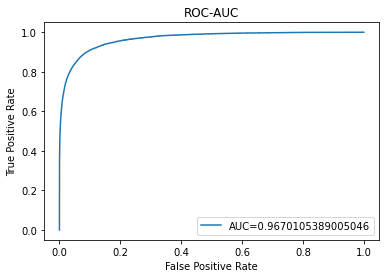

In [50]:
log_predict_proba1 = log_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(remaining['toxic'], log_predict_proba1)
auc = metrics.roc_auc_score(remaining['toxic'], log_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Найдем лучшую отсечку по вероятности

In [44]:
f1 = 0.0
threshold = 0.1
for thresh in range(1, 10):
  predict_cv_proba = (log_predict_proba1 >= thresh/10).astype(bool) 
  print(metrics.f1_score(remaining['toxic'], predict_cv_proba))
  if f1<metrics.f1_score(remaining['toxic'], predict_cv_proba):
      threshold = thresh/10
      f1 = metrics.f1_score(remaining['toxic'], predict_cv_proba)
print(threshold)

0.5651620075503161
0.6789351648029115
0.727110405713719
0.7541335623792141
0.7682551737231821
0.7725325325325325
0.7675707448148459
0.7541243934715482
0.7188796680497925
0.6


## Предсказания выбранной модели

In [45]:
predict_log = logreg.predict(x_test)
print(predict_log)
print(predict_log.sum())
print(y_test.sum())
print(metrics.f1_score(y_test, predict_log))

[0 0 0 ... 0 0 0]
3503
3237
0.784272997032641


In [46]:
predict_final = (logreg.predict_proba(x_test)[:,1] >= threshold).astype(bool) 
print(predict_final)
print(predict_final.sum())
print(y_test.sum())
print(metrics.f1_score(y_test, predict_final))

[False False False ... False False False]
3200
3237
0.7901196209414324


### Построим матрицу

[[0.96995318 0.03004682]
 [0.18350324 0.81649676]]


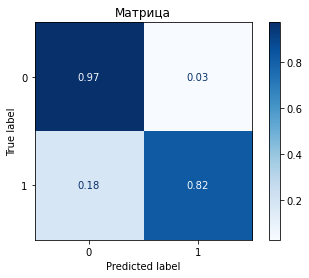

In [47]:

disp = metrics.ConfusionMatrixDisplay.from_estimator(
        logreg,
        x_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize='true',
    )
disp.ax_.set_title('Матрица')

print(disp.confusion_matrix)

plt.show()

## Выводы

    * Для классификации комментариев были предоставлены 160 тысяч текстов с проведенной категоризацией.
    * Данные предоставлены в подходящем формате, пропусков и ошибок в них не обнаружено.
    * Для выбора модели использовалась половина данных из-за ограниченности вычислительных ресурсов.
    * Наилучшие результаты показала логистическая регрессия, ее показатель на валидационной выборке составил немного меньше 0.759 %. 
    Дальнейшая работа велась с этой моделью.
    * На основании ROC-кривой было принято решение увеличить отсеку до 60% вероятности. Это прибавило к метрике f1 еще около 3%.
    
    Вывод:
    Для анализа текстов из библиотеки sklearn больше всего подходит модель LogisticRegression. 
    
    комментарии классифицированы.
    